<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_sep_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew, boxcox_normmax

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_test.csv')

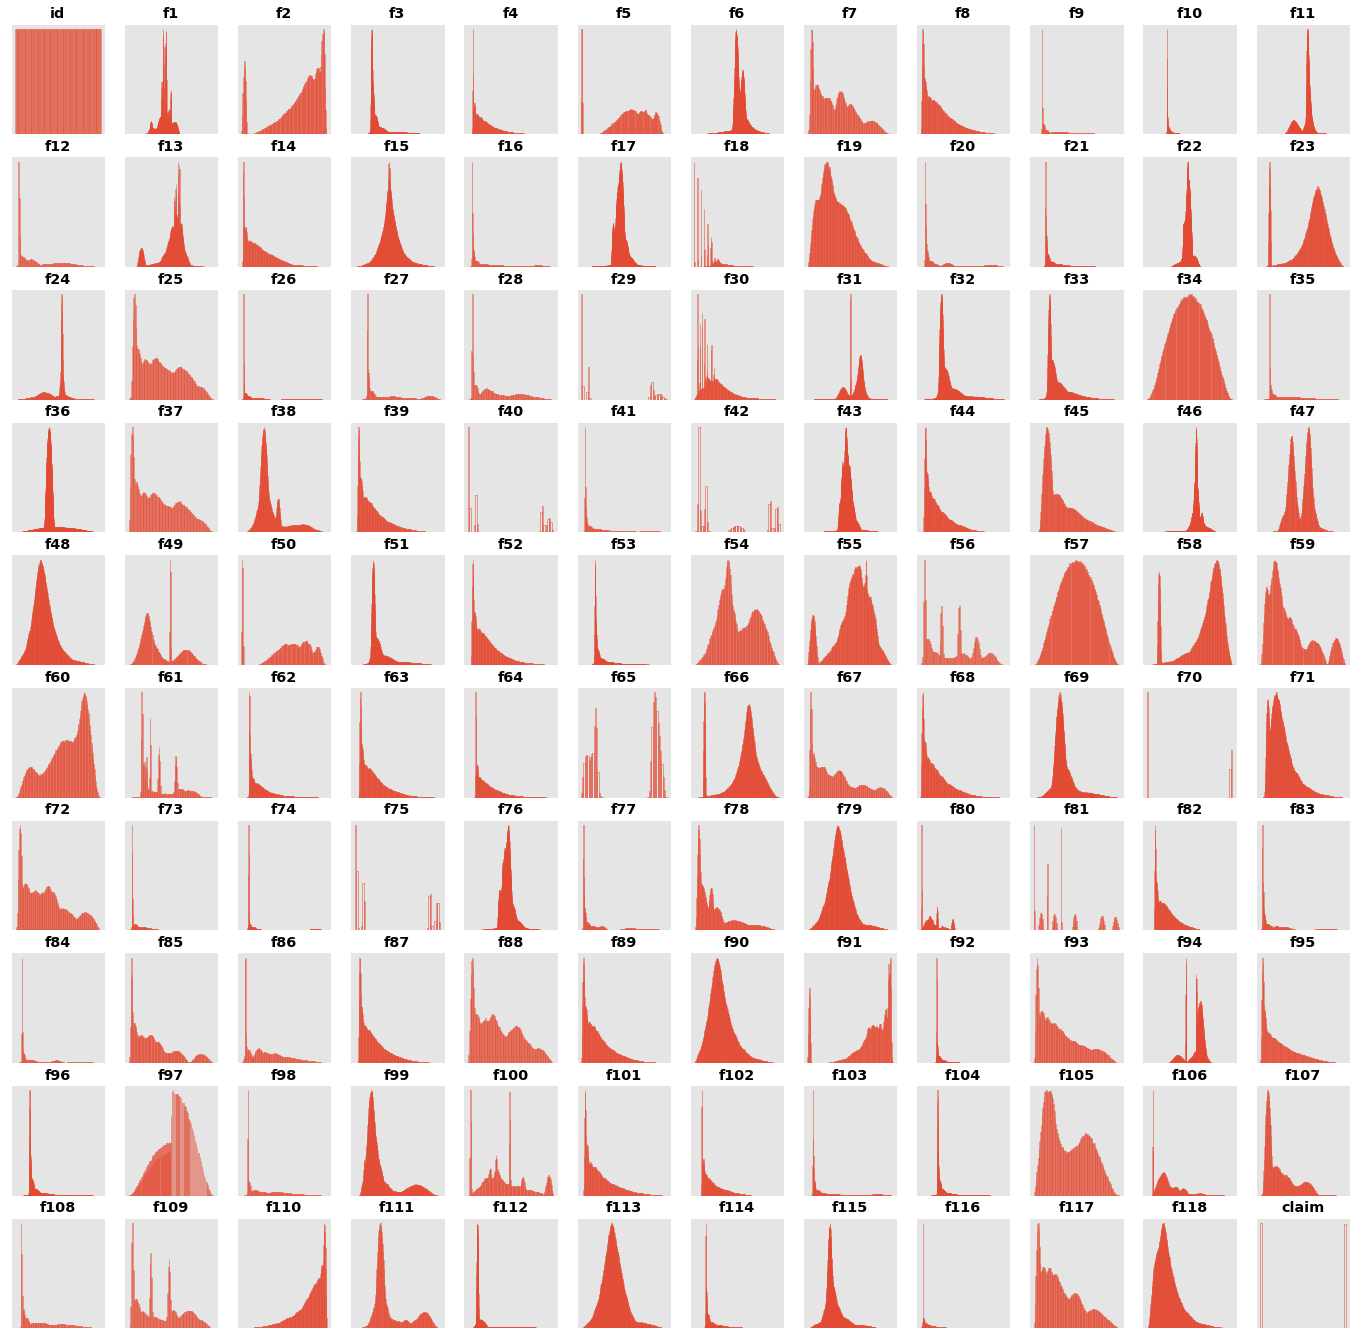

In [ ]:
plt.figure(figsize=(24,24))
for i, j in enumerate(train.columns):
  plt.subplot(10, 12, i+1)
  sns.histplot(x=train[j], fill=False)
  plt.xlabel('')
  plt.ylabel('')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'{j}', fontweight='bold')

In [3]:
train['na'] = train.isnull().sum(axis=1)
test['na'] = test.isnull().sum(axis=1)

In [ ]:
!pip install catboost
!pip install optuna

In [4]:
from sklearn.impute import SimpleImputer
import catboost
import optuna
import lightgbm
import xgboost
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# data splits

x_train = train.drop(columns=['claim', 'id'])
y_train = train['claim']
x_test = test.drop(columns=['id'])

train_columns = x_train.columns
test_columns = x_test.columns

In [6]:
# 누락값(impute)
x_train = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(x_train), columns=train_columns)
x_test = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(x_test), columns=test_columns)

In [7]:
# scaling
sc = StandardScaler().fit(x_train)
x_train = pd.DataFrame(sc.transform(x_train), columns=train_columns)
x_test = pd.DataFrame(sc.transform(x_test), columns=test_columns)

# mc = MinMaxScaler().fit(x_train)
# x_train = pd.DataFrame(mc.transform(x_train), columns=train_columns)
# x_test = pd.DataFrame(mc.transform(x_test), columns=test_columns)

# Catboost [LB : 0.81691]

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(eval_metric='AUC', task_type='GPU', iterations=5000)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

In [12]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 40000, step=1000),
              'task_type':"GPU",
              'eval_metric':'AUC',
              'objective':'CrossEntropy',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
               }
    model = catboost.CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [13]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-09-13 07:56:09,381] A new study created in memory with name: no-name-0dbef287-09e1-47b5-ade5-1a985147a1e3
[I 2021-09-13 07:56:48,848] Trial 0 finished with value: 0.8144058572096611 and parameters: {'iterations': 35000, 'learning_rate': 0.10042847096426201, 'reg_lambda': 67.66421222831185, 'subsample': 0.7062408649780905, 'random_strength': 42.78632082550044, 'depth': 2, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 4}. Best is trial 0 with value: 0.8144058572096611.
[I 2021-09-13 07:56:56,927] Trial 1 finished with value: 0.8084658251739898 and parameters: {'iterations': 6000, 'learning_rate': 0.4434707359537628, 'reg_lambda': 96.57915899089524, 'subsample': 0.33731867635634405, 'random_strength': 23.476853690228484, 'depth': 6, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 6}. Best is trial 0 with value: 0.8144058572096611.
[I 2021-09-13 07:57:07,695] Trial 2 finished with value: 0.8103616288696683 and parameters: {'iterations': 19000, 'learning_rate': 0.33165

Number of finished trials: 50
Best trial: score 0.8148214079486926, params {'iterations': 27000, 'learning_rate': 0.01490106696393073, 'reg_lambda': 51.37333283466633, 'subsample': 0.7010740293501646, 'random_strength': 20.72907444912073, 'depth': 6, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 5}


In [14]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_cat = {
    'iterations'  :study.best_params['iterations'],
    'task_type':"GPU",
    'eval_metric':'AUC',
    'objective':'CrossEntropy',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth':study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Depthwise'
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

0:	learn: 0.8029743	test: 0.8008861	best: 0.8008861 (0)	total: 23.1ms	remaining: 10m 23s
100:	learn: 0.8162118	test: 0.8073810	best: 0.8073810 (100)	total: 2.05s	remaining: 9m 6s
200:	learn: 0.8196804	test: 0.8086539	best: 0.8086539 (200)	total: 4.03s	remaining: 8m 56s
300:	learn: 0.8231091	test: 0.8099018	best: 0.8099018 (300)	total: 6.09s	remaining: 9m
400:	learn: 0.8257646	test: 0.8107999	best: 0.8107999 (400)	total: 8.08s	remaining: 8m 55s
500:	learn: 0.8279712	test: 0.8114739	best: 0.8114739 (500)	total: 10s	remaining: 8m 48s
600:	learn: 0.8299211	test: 0.8120100	best: 0.8120100 (600)	total: 11.9s	remaining: 8m 42s
700:	learn: 0.8317125	test: 0.8124568	best: 0.8124568 (700)	total: 13.9s	remaining: 8m 40s
800:	learn: 0.8332410	test: 0.8128031	best: 0.8128031 (800)	total: 15.9s	remaining: 8m 39s
900:	learn: 0.8347802	test: 0.8131160	best: 0.8131160 (900)	total: 17.9s	remaining: 8m 37s
1000:	learn: 0.8362186	test: 0.8133439	best: 0.8133439 (1000)	total: 19.8s	remaining: 8m 33s
1100:	

# LGBM [LB : 0.81742]

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM

!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

In [15]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
            "n_estimators": trial.suggest_int('n_estimators', 2000, 40000, step=500),
            "objective": "binary",
            "metric": "AUC", 
            "verbosity": -1,
            
            "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 1.0),
            "reg_alpha": trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
            "reg_lambda": trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
            "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            "subsample": trial.suggest_uniform('subsample', 0.4, 1.0),
            "subsample_freq": trial.suggest_categorical("subsample_freq", [1,2]),
            "max_depth": trial.suggest_int('max_depth', 1, 14),
            "num_leaves" : trial.suggest_int('num_leaves', 2, 256),
            "min_child_weight" : trial.suggest_categorical("min_child_weight", [128,256]),
            "min_child_samples": trial.suggest_int('min_child_samples', 1, 200),
            "device": "gpu"
        }
    model = lightgbm.LGBMClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [16]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-09-13 08:41:45,108] A new study created in memory with name: no-name-8e002f03-cdab-450d-a907-764dcfd09cd1
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'print_evaluation()' callback via 'callbacks' argument instead.

[I 2021-09-13 08:42:02,257] Trial 0 finished with value: 0.8041711752152122 and parameters: {'n_estimators': 30500, 'learning_rate': 0.9099708508566632, 'reg_alpha': 5.222493260885809, 'reg_lambda': 8.225305916317373, 'colsample_bytree': 0.4300418361516761, 'subsample': 0.6281670131967995, 'subsample_freq': 2, 'max_depth': 9, 'num_leaves': 56, 'min_child_weight': 128, 'min_child_samples': 26}. Best is t

KeyboardInterrupt: ignored

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_lgbm = {
    "n_estimators": study.best_params['n_estimators'],
    "objective": "binary",
    "metric": "AUC", 
    "verbosity": -1,
    "learning_rate": study.best_params['learning_rate'],
    "reg_alpha": study.best_params['reg_alpha'],
    "reg_lambda": study.best_params['reg_lambda'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": study.best_params['subsample_freq'],
    "max_depth": study.best_params['max_depth'],
    "num_leaves" : study.best_params['num_leaves'],
    "min_child_weight" : study.best_params['min_child_weight'],
    "min_child_samples": study.best_params['min_child_samples'],
    "device": "gpu" 
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgbm = lightgbm.LGBMClassifier(**params_lgbm)
  model_lgbm.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_lgbm.predict_proba(x_test)[:,1] / sf.n_splits

# XGBoost

In [ ]:
def objective(trial, data=x_train, target=y_train):

  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
  params = {
      'n_estimators' : trial.suggest_int('n_estimators', 2000, 40000, step=500),
      'objective' : trial.suggest_categorical('objective', ['binary:logistic', 'binary:logitraw', 'binary:hinge']),
      'eval_metric' : 'auc',
      'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 0.8),
      'reg_alpha' : trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
      'reg_lambda' : trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
      'colsample_bytree' : trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
      'subsample' : trial.suggest_uniform('subsample', 0.4, 1.0),
      'subsample_freq' : trial.suggest_categrical('subsample_freq', [1,2]),
      'max_depth' : trial.suggest_int('max_depth', 1, 14),
      'num_leaves' : trial.suggest_int('num_leaves', 2, 256),
      'min_child_weight' : trial.suggest_categorical('min_child_weight', [128, 256]),
      'min_child_sample' : trial.suggest_int('min_child_sample', 1, 200),
      'tree_method' : 'gpu_hist',
      # 'grow_policy' : 'lossguide'
   }
  model = xgboost.XGBClassifier(**params)
  model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

  y_preds = model.predict_proba(X_test)[:,1]

  AUC = roc_auc_score(y_test, y_preds)

  return AUC

In [ ]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
            "n_estimators": trial.suggest_int('n_estimators', 2000, 40000, step=500),
            "objective": trial.suggest_categorical('objective', ["binary:logistic", 'binary:logitraw', 'binary:hinge']),
            "eval_metric": "auc",
            "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 1.0),
            "reg_alpha": trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
            "reg_lambda": trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
            "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            "subsample": trial.suggest_uniform('subsample', 0.4, 1.0),
            "subsample_freq": trial.suggest_categorical("subsample_freq", [1,2]),
            "max_depth": trial.suggest_int('max_depth', 1, 14),
            "num_leaves" : trial.suggest_int('num_leaves', 2, 256),
            "min_child_weight" : trial.suggest_categorical("min_child_weight", [128,256]),
            "min_child_samples": trial.suggest_int('min_child_samples', 1, 200),
            'tree_method' : 'gpu_hist',
            # 'grow_policy' : 'lossguide' 
        }
    model = xgboost.XGBClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [10]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-09-13 04:41:14,279] A new study created in memory with name: no-name-793b83c7-27da-4a2e-b3a9-c9239e33ed0f
[I 2021-09-13 04:41:24,521] Trial 0 finished with value: 0.770815382213412 and parameters: {'n_estimators': 3500, 'objective': 'binary:hinge', 'learning_rate': 0.9794597880272967, 'reg_alpha': 3.995648984627615, 'reg_lambda': 4.674245984470946, 'colsample_bytree': 0.6352179037432102, 'subsample': 0.40820098375965347, 'subsample_freq': 1, 'max_depth': 12, 'num_leaves': 146, 'min_child_weight': 256, 'min_child_samples': 72}. Best is trial 0 with value: 0.770815382213412.
[I 2021-09-13 04:41:31,448] Trial 1 finished with value: 0.7712953717586515 and parameters: {'n_estimators': 39500, 'objective': 'binary:hinge', 'learning_rate': 0.939869886420681, 'reg_alpha': 5.37087610756946, 'reg_lambda': 2.4218994111086216, 'colsample_bytree': 0.5479271965316407, 'subsample': 0.9260409137039851, 'subsample_freq': 2, 'max_depth': 2, 'num_leaves': 5, 'min_child_weight': 128, 'min_child_sam

Number of finished trials: 50
Best trial: score 0.8150381617627394, params {'n_estimators': 11500, 'objective': 'binary:logistic', 'learning_rate': 0.014050826113688283, 'reg_alpha': 9.976968332424882, 'reg_lambda': 9.898964878986382, 'colsample_bytree': 0.7763813378509938, 'subsample': 0.804753074483424, 'subsample_freq': 1, 'max_depth': 5, 'num_leaves': 188, 'min_child_weight': 256, 'min_child_samples': 198}


In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_xgb = {
    "n_estimators": study.best_params['n_estimators'],
    "objective": study.best_params['objective'],
    "eval_metric": "auc",
    "learning_rate": study.best_params['learning_rate'],
    "reg_alpha": study.best_params['reg_alpha'],
    "reg_lambda": study.best_params['reg_lambda'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": study.best_params['subsample_freq'],
    "max_depth": study.best_params['max_depth'],
    "num_leaves" : study.best_params['num_leaves'],
    "min_child_weight" : study.best_params['min_child_weight'],
    "min_child_samples": study.best_params['min_child_samples'],
    'tree_method' : 'gpu_hist',
     # 'grow_policy' : 'lossguide' 
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict_proba(x_test)[:,1] / sf.n_splits

[0]	validation_0-auc:0.800516	validation_1-auc:0.80056
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 70 rounds.
[100]	validation_0-auc:0.810117	validation_1-auc:0.805942
[200]	validation_0-auc:0.813203	validation_1-auc:0.807627
[300]	validation_0-auc:0.815274	validation_1-auc:0.808622
[400]	validation_0-auc:0.817263	validation_1-auc:0.809617
[500]	validation_0-auc:0.818878	validation_1-auc:0.810479
[600]	validation_0-auc:0.820159	validation_1-auc:0.811125
[700]	validation_0-auc:0.821241	validation_1-auc:0.811573
[800]	validation_0-auc:0.82222	validation_1-auc:0.81203
[900]	validation_0-auc:0.82313	validation_1-auc:0.812393
[1000]	validation_0-auc:0.823868	validation_1-auc:0.812703
[1100]	validation_0-auc:0.82452	validation_1-auc:0.81294
[1200]	validation_0-auc:0.825209	validation_1-auc:0.813135
[1300]	validation_0-auc:0.825871	validation_1-auc:0.813343
[1400]	validation_0-auc:0.826482	va

In [ ]:
cat = model_cat(**params_cat)
xgb = model_xgb(**params_xgb)
lgb = model_lgb(**params_lgb)

In [12]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_sample_solution.csv')
submit['claim'] = preds
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/submit6.csv', index=False)
submit

,id,claim
0,957919,0.584806
1,957920,0.121539
2,957921,0.629069
3,957922,0.127778
4,957923,0.152864
...,...,...
493469,1451388,0.823289
493470,1451389,0.111646
493471,1451390,0.756025
493472,1451391,0.136460
